# Non-linear dictionary learning for positive definite matrices
#### Problem Setup
Given $k$ positive definite matrices $\mathbf{P}_j \in \mathbb{R}^{d \times d}$, the dictionary learning problem is the following
$$ \min_{\substack{\mathbf{D} \in \mathbb{R}^{d \times d \times m}, D \succ 0}\\ \mathbf{A} \in \mathbb{R}^{k \times m}, \mathbf{A}\mathbb{1}_m = 1} \sum_{j=1}^{j=K} d_{\mathcal{B}}^2(\underbrace{P(\mathbf{D},\mathbf{A}_j)}_{\hat{\mathbf{P}}_j},\mathbf{P}_j),$$
where $d_{\mathcal{B}}$ denotes the Buress metric between positive definite matrices and $\mathbf{P}$ is the barycenter operator defined below.

#### Proposed Approach
The objective above is minimized by alternating updates over $m$ atoms, i.e. the slices of $3^{rd}$ order tensor $\mathbf{D}\in \mathbb{R}^{d \times d \times m}$,  and $k$ codewords on the simplex. The codewords are rows of the matrix $\mathbf{A} \in \mathbb{R}^{k \times m}$. The approximation $\hat{\mathbf P}$ is the barycenter of the dictionary atoms $\mathbf{D}$ with weights $\alpha$. The barycenter operator $P(\mathbf{D},\mathbf{A}_j)$ that approximates the input example $\mathbf{P}_j$ is obtained by the following fixed point iteration:

$$ \hat{\mathbf{P}}_j^{t+1} = \sum_{i=1}^{i=m}\mathbf{A}_{ji} \bigg(\sqrt{\hat{\mathbf{P}}^{t}} \mathbf{D}_i \sqrt{\hat{\mathbf{P}}^{t}} \bigg)^{1/2},$$
$\hat{\mathbf{P}}^{0} = \mathbf{I}$.

In [31]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import scipy
from scipy import linalg, optimize
from numpy.linalg import matrix_rank
from numpy import linalg as LA
from scipy.linalg import sqrtm
from matplotlib.patches import Ellipse
from torch.autograd import Variable
from scipy.stats import gengamma
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from time import time
import matplotlib.colors as colors
import sys


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Function routines/code description
The following code contains a vectorized (i.e. without for loops) implementation of **i)** projection onto the simplex `proj_vec`, **ii)** barycenter computation via the fixed point iteration above `barycenter_torch`, and **iii)** the buress loss computation, also given above `loss_vec`.

In [32]:
# project each row of matrix alpha onto the simplex 
def proj_vec(M,K,alpha,mat0,mat1):
    [U,_]    = torch.sort(alpha,descending=True)
    U_       = U
    U_       = U_ + torch.matmul(1 - torch.matmul(U_,mat0),mat1)
    rho      = torch.tensor([torch.max((U_[i,:] > 0).nonzero()) for i in range (K)])
    U[torch.arange(M) > rho.unsqueeze(1)] = 0
    rho      = rho+1
    rho      = (1-torch.sum(U,axis=1))/rho
    alpha    = alpha + rho.unsqueeze(1)
    alpha    = torch.max(alpha,torch.tensor([0.0],dtype=torch.float32))
    return alpha

# compute the barycenter of the atoms in D with corresponding codes in the rows of matrix alpha 
def barycenter_torch(D,alpha,sqrt_iter,fixed_iter,k,m,d):
    init = torch.eye(D.shape[1],dtype=torch.float32)
    init = init.unsqueeze(0).repeat(alpha.shape[0],1,1)
    for t in range(fixed_iter):
        init = sqrt_newton_schulz_autograd(init, sqrt_iter,torch.float32)
        init = torch.matmul(torch.matmul(init.unsqueeze(1),D.unsqueeze(0)),init.unsqueeze(1))
        init = torch.reshape(init,(k*m,d,d))
        init = sqrt_newton_schulz_autograd(init, sqrt_iter,torch.float32)
        init = torch.reshape(init,(k,m,d,d))
        init = alpha.unsqueeze(-1).unsqueeze(-1)*init
        init = torch.sum(init,axis=1)
    return init

# compute the forward loss i.e. the Buress loss between y_hat = Barycenter(D,alpha) and y
def loss_vec(P,P_sqrt,P_h):
    C_b = torch.matmul(torch.matmul(P_sqrt, P_h), P_sqrt)
    C_b = sqrt_newton_schulz_autograd(C_b, numIters=sqrt_iter, dtype=torch.float32)
    loss = P+P_h-2*C_b #recon. loss 3-way tensor
    loss = torch.sum(torch.diagonal(loss,dim1=-2,dim2=-1).flatten())
    return loss
# alternating minimization -  update the dictionary atoms

def D_update(L,alpha,P,P_sqrt,e_I,t_inner,fixed_iter,sqrt_iter,K,M,D,gamma):
    for _ in range(t_inner):
        D_hat = torch.matmul(L, torch.transpose(L, 2, 1)) + e_I
        P_h = barycenter_torch(D_hat.detach(), alpha, sqrt_iter, fixed_iter, K, M, D)
        P_h = sqrt_newton_schulz_autograd(P_h, sqrt_iter,torch.float32)
        P_h = torch.matmul(torch.matmul(P_h.unsqueeze(1),D_hat.unsqueeze(0)),P_h.unsqueeze(1))
        P_h = torch.reshape(P_h,(K*M,D,D))
        P_h = sqrt_newton_schulz_autograd(P_h, sqrt_iter,torch.float32)
        P_h = torch.reshape(P_h,(K,M,D,D))
        P_h = alpha.unsqueeze(-1).unsqueeze(-1)*P_h
        P_h = torch.sum(P_h,axis=1)
        loss = loss_vec(P,P_sqrt, P_h)
        loss.backward()
        with torch.no_grad():
            L = L - gamma * L.grad
        L.requires_grad = True
    return L,loss

# alternating minimization -  update the codes
def alpha_update(L,alpha,P,P_sqrt,e_I,t_inner,fixed_iter,sqrt_iter,K,M,D,gamma,mat0,mat1):
    D_hat = torch.matmul(L, torch.transpose(L, 2, 1)) + e_I
    for _ in range(t_inner):
        P_h = barycenter_torch(D_hat, alpha.detach(), sqrt_iter, fixed_iter, K, M, D)
        P_h = sqrt_newton_schulz_autograd(P_h, sqrt_iter,torch.float32)
        P_h = torch.matmul(torch.matmul(P_h.unsqueeze(1),D_hat.unsqueeze(0)),P_h.unsqueeze(1))
        P_h = torch.reshape(P_h,(K*M,D,D))
        P_h = sqrt_newton_schulz_autograd(P_h, sqrt_iter,torch.float32)
        P_h = torch.reshape(P_h,(K,M,D,D))
        P_h = alpha.unsqueeze(-1).unsqueeze(-1)*P_h
        P_h = torch.sum(P_h,axis=1)
        loss = loss_vec(P,P_sqrt, P_h)
        loss.backward()
        with torch.no_grad():
            alpha = alpha - gamma * alpha.grad
            alpha = proj_vec(M,K,alpha,mat0,mat1)
        alpha.requires_grad = True
    return alpha

# compute the matrix square root of each matrix in 3-d tensor A; each matrix is stored along the last changing index [i,:,:]
def sqrt_newton_schulz_autograd(A, numIters, dtype):
    batchSize = A.data.shape[0]
    dim = A.data.shape[1]
    normA = A.mul(A).sum(dim=1).sum(dim=1).sqrt()
    Y = A.div(normA.view(batchSize, 1, 1).expand_as(A))
    I = Variable(torch.eye(dim, dim).view(1, dim, dim).
                 repeat(batchSize, 1, 1).type(dtype), requires_grad=False)
    Z = Variable(torch.eye(dim, dim).view(1, dim, dim).
                 repeat(batchSize, 1, 1).type(dtype), requires_grad=False)
    for i in range(numIters):
        T = 0.5 * (3.0 * I - Z.bmm(Y))
        Y = Y.bmm(T)
        Z = T.bmm(Z)
    sA = Y * torch.sqrt(normA).view(batchSize, 1, 1).expand_as(A)
    return sA

### Synthetic data generation
Generate $K$ positivie definite (PD) matrices as data points, torch tensor $P \in \mathbb{R}^{K \times D \times D}$,  as barycenters of of $M$ PD dictionary atoms, torch tensor $D \in \mathbb{R}^{M \times D \times D}$, with weights stored in torch tensor  $\mathrm{alpha} \in \mathbb{R}^{K \times M}$.



In [33]:
D = 3
M = 3
K = 10
sqrt_iter  = 25      # sqrt iterations for 
fixed_iter = 25
datatype   = torch.float32
e_I        = 0.001*torch.eye(D)
L_star     = np.random.randn(M,D,D)
L_star     = torch.tensor(L_star)
L_star     = L_star.to(datatype)
D_star     = L_star@torch.transpose(L_star,1,2) + e_I
alpha_star = np.random.rand(K,M)
alpha_star = np.diag(1/np.sum(alpha_star,axis=1))@alpha_star
alpha_star = torch.tensor(alpha_star)
alpha_star = alpha_star.to(datatype)
P          = barycenter_torch(D_star,alpha_star,sqrt_iter,fixed_iter,K,M,D)
P_sqrt     = sqrt_newton_schulz_autograd(P, sqrt_iter, datatype)

### Optimization by alternating minimization
The objective below is alternately minimized over the dictionary atoms $\mathbf{D}$ and the codes $\mathbf{A}$.  
$$ \min_{\substack{\mathbf{D} \in \mathbb{R}^{d \times d \times m}, D \succ 0}\\} \sum_{j=1}^{j=K} d_{\mathcal{B}}^2(P(\mathbf{D},\mathbf{A}_j),\mathbf{P}_j)$$

- The positive definite constraint on the dictionary atoms is enforced by the following reparametrization
$$\min_{\mathbf{L} \in \mathbb{R}^{d \times d \times M}} \sum_{j=1}^{j=K} d_{\mathcal{B}}^2(P(\mathbf{L}\mathbf{L}^{\intercal},\mathbf{A}_j),\mathbf{P}_j),$$
where we have reparametrized $\mathbf{D}[i,:,:]= \mathbf{L}_i\mathbf{L}_i^{\intercal}$. In order to ensure the positive definite $\epsilon \mathbf{I}$, where $\mathbf{I}$ denotes the identity matrix, is added to $\mathbf{L}\mathbf{L}^{\intercal}$.
- The update on the dictionary atoms is done by stochastic gradient descent with a configurable batch size. The update on the codes is done by gradient descent. 
- The dictionary atoms are updated by calling the function `D_update`. The codes are updated by calling the function `alpha_update`.
- To speed up the backward pass for gradient descent, the gradient is only evaluated at last iteration of the fixed point iteration for barycenter computation (above).


In [34]:
# global variables passed to the simplex projection function
mat0       = torch.zeros(M,M)
mat0[torch.arange(M)>=torch.transpose(torch.arange(M).unsqueeze(0),1,0)] = 1
mat0       = mat0.to(dtype=torch.float32)
mat1       = torch.diag(1/(torch.arange(M)+1))
mat1       = mat1.to(dtype=torch.float32)
#--------------------------------
L = P_sqrt[np.random.randint(low=0, high=K, size=(M))].clone().detach().requires_grad_(True)  # CUDA
alpha = np.random.rand(K, M)
alpha = np.diag(1 / np.sum(alpha, axis=1)) @ alpha
alpha = torch.tensor(alpha, requires_grad=True, dtype=torch.float32)
batch_size = 10
gamma      = 0.1  # step size
num_epochs = 200
loss_iter  = np.zeros(int(num_epochs*K/(10*batch_size)))
t = 0
start      = time()
for _ in range(num_epochs):
    alpha = alpha_update(L.detach(),alpha,P[:K],P_sqrt[:K],e_I,15,fixed_iter,sqrt_iter,K,M,D,gamma,mat0,mat1)
    for i in range(0, K, batch_size):
        L,loss = D_update(L, alpha.detach()[i:i+batch_size],P[i:i+batch_size],P_sqrt[i:i+batch_size], e_I,1, fixed_iter,sqrt_iter,batch_size,M,D,gamma) #batch gradient descent
        if t%10 == 0:
            print(loss)
            loss_iter[int(t/10)] = loss
        t = t + 1
        idx    = np.random.permutation(K)
        P[0:K] = P[idx] 
        alpha  = alpha[idx]
        P_sqrt[0:K] = P_sqrt[idx]
        alpha = alpha.clone().detach().requires_grad_(True) #requires_grad = True for alpha update iteration
    stop = time()

print(f"dl+sc time   = {stop - start:.2f}")

tensor(1.6855, grad_fn=<SumBackward0>)
tensor(0.1395, grad_fn=<SumBackward0>)
tensor(0.0834, grad_fn=<SumBackward0>)
tensor(0.0594, grad_fn=<SumBackward0>)
tensor(0.0463, grad_fn=<SumBackward0>)
tensor(0.0381, grad_fn=<SumBackward0>)
tensor(0.0314, grad_fn=<SumBackward0>)
tensor(0.0253, grad_fn=<SumBackward0>)
tensor(0.0204, grad_fn=<SumBackward0>)
tensor(0.0168, grad_fn=<SumBackward0>)
tensor(0.0148, grad_fn=<SumBackward0>)
tensor(0.0130, grad_fn=<SumBackward0>)
tensor(0.0115, grad_fn=<SumBackward0>)
tensor(0.0110, grad_fn=<SumBackward0>)
tensor(0.0101, grad_fn=<SumBackward0>)
tensor(0.0101, grad_fn=<SumBackward0>)
tensor(0.0094, grad_fn=<SumBackward0>)
tensor(0.0095, grad_fn=<SumBackward0>)
tensor(0.0091, grad_fn=<SumBackward0>)
tensor(0.0086, grad_fn=<SumBackward0>)
dl+sc time   = 633.54


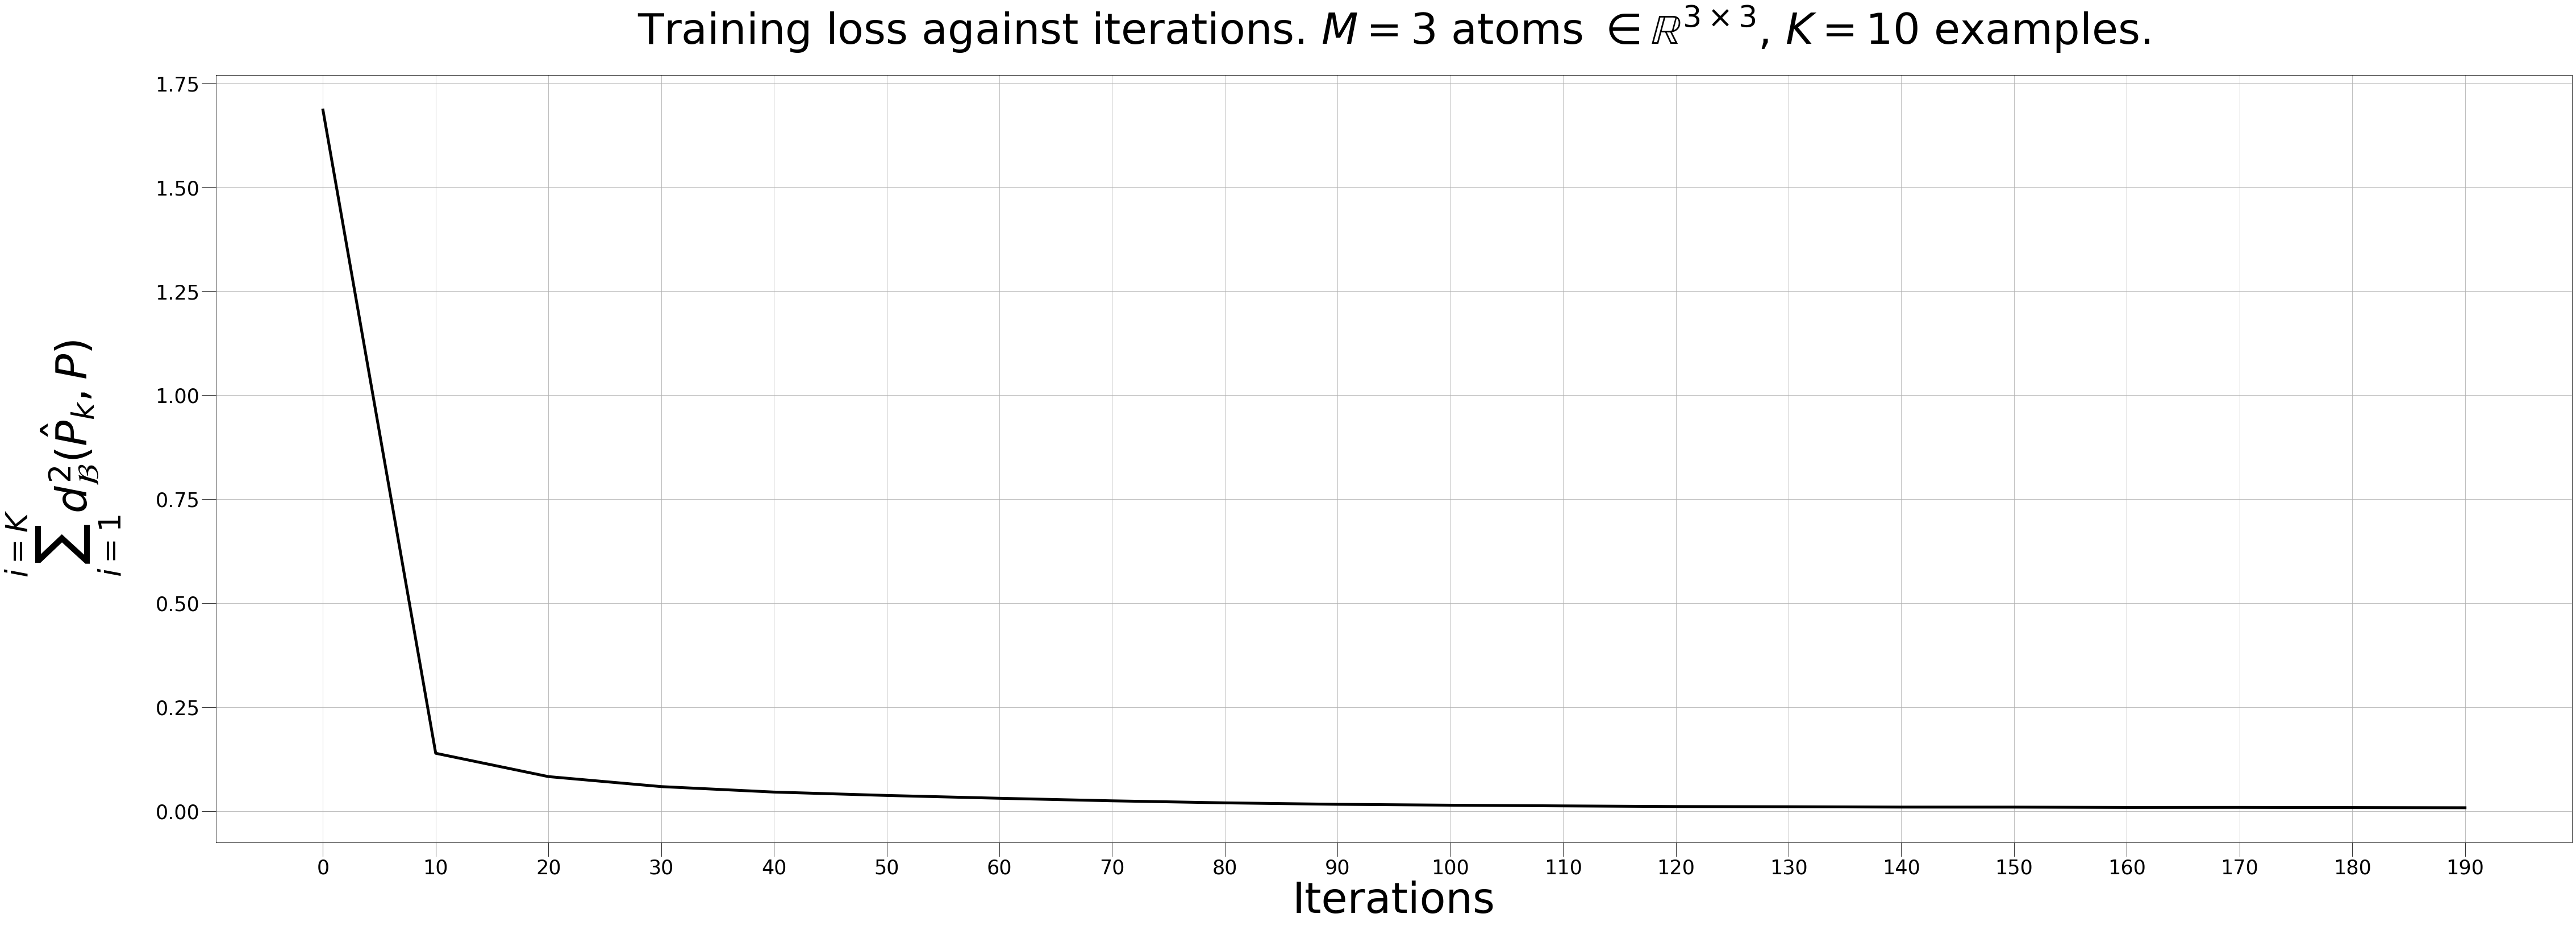

In [38]:
fig, ax    = plt.subplots(nrows=1,ncols=1, figsize=(72, 25))
ax.plot(range(int(t/10)),loss_iter,color = 'k', linewidth = 5)
ax.set_title(r"""Training loss against iterations. $M = %d$ atoms $\in \mathbb{R}^{%d \times %d}$, $K = %d$ examples."""%(M,D,D,K),fontsize='75',pad=55)
ax.set_xlabel(r'Iterations', fontsize = '75')
ax.set_ylabel(r'$\sum_{i=1}^{i=K} d_\mathcal{B}^2(\hat{P}_k,P)$',fontsize = '75', labelpad = 55)
ax.set_xticks(np.arange(int(t/10)))
ax.set_xticklabels(10*np.arange(int(t/10)))
ax.tick_params(labelsize=35,length = 25)
ax.grid('on') 
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.15)
plt.show()
fig.savefig('wout_kds.png', bbox_inches='tight')   

In [39]:
def plot_barycenter_example_3d(A,weights,pp,M):
    A = A.numpy()
    weights = weights.numpy()
    ellipNumber = 2*M + 2
    norm = colors.Normalize(vmin=0, vmax=ellipNumber/2)
    cmap = cm.jet
    m    = cm.ScalarMappable(norm=norm, cmap=cmap)
    w    = 45
    fig  = plt.figure(figsize = (w,0.45*w),tight_layout = False)
    plt.xlabel('Dictionary learning for positive definite matrices. \n Left $3$ columns Top (Bottom). True (learnt) dictionary atoms; $\lambda$ are the eigenvalues of the dictionary atoms. Fourth column: True (Approximation) of data point.', Fontsize = 33)
    t = 0
    t1 = 0
    t2 = 0
    for indx in range(ellipNumber):
        U, s, rotation = linalg.svd(A[indx,:,:])
        radii = 1.0/np.sqrt(s) * 0.3 #reduce radii by factor 0.3 
        u = np.linspace(0.0, 2.0 * np.pi, 60)
        v = np.linspace(0.0, np.pi, 60)
        x = radii[0] * np.outer(np.cos(u), np.sin(v))
        y = radii[1] * np.outer(np.sin(u), np.sin(v))
        z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
        for i in range(len(x)):
            for j in range(len(x)):
                [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) 
        ax = fig.add_subplot(2, int(ellipNumber/2), indx+1, projection='3d',aspect = 'auto')
        ax.plot_surface(x, y, z,  rstride=3, cstride=3,  color=m.to_rgba(indx%(ellipNumber/2)), linewidth=0.1, alpha=1, shade=True)
        if(indx == M): 
            ax.set_title(r'$\mathbf{P} \,\,\, \lambda_1 = %0.2f,\lambda_2 = %0.2f,\lambda_3 = %0.2f$'%(s[0],s[1],s[2]), fontsize = 35)
        elif(indx == 2*M+1):
            ax.set_title(r'$\widehat \mathbf{P} \,\,\, \lambda_1 = %0.2f,\lambda_2 = %0.2f,\lambda_3 = %0.2f$'%(s[0],s[1],s[2]), fontsize = 35)
        elif(indx < M ):
            t1 = t1+1
            ax.set_title(r'$\mathbf{D}_%d \,\,\, \lambda = \{%0.2f,%0.2f,%0.2f\}$'%(t1,s[0],s[1],s[2]), fontsize = 35)
            t = t+1
        else:
            t2 = t2+1
            ax.set_title(r'$\widehat{\mathbf{D}}_%d \,\,\, \lambda = \{%0.2f,%0.2f,%0.2f\}$'%(t2,s[0],s[1],s[2]), fontsize = 35)
            t = t+1
    plt.tight_layout()
    plt.show()
    pp.savefig(fig)
 

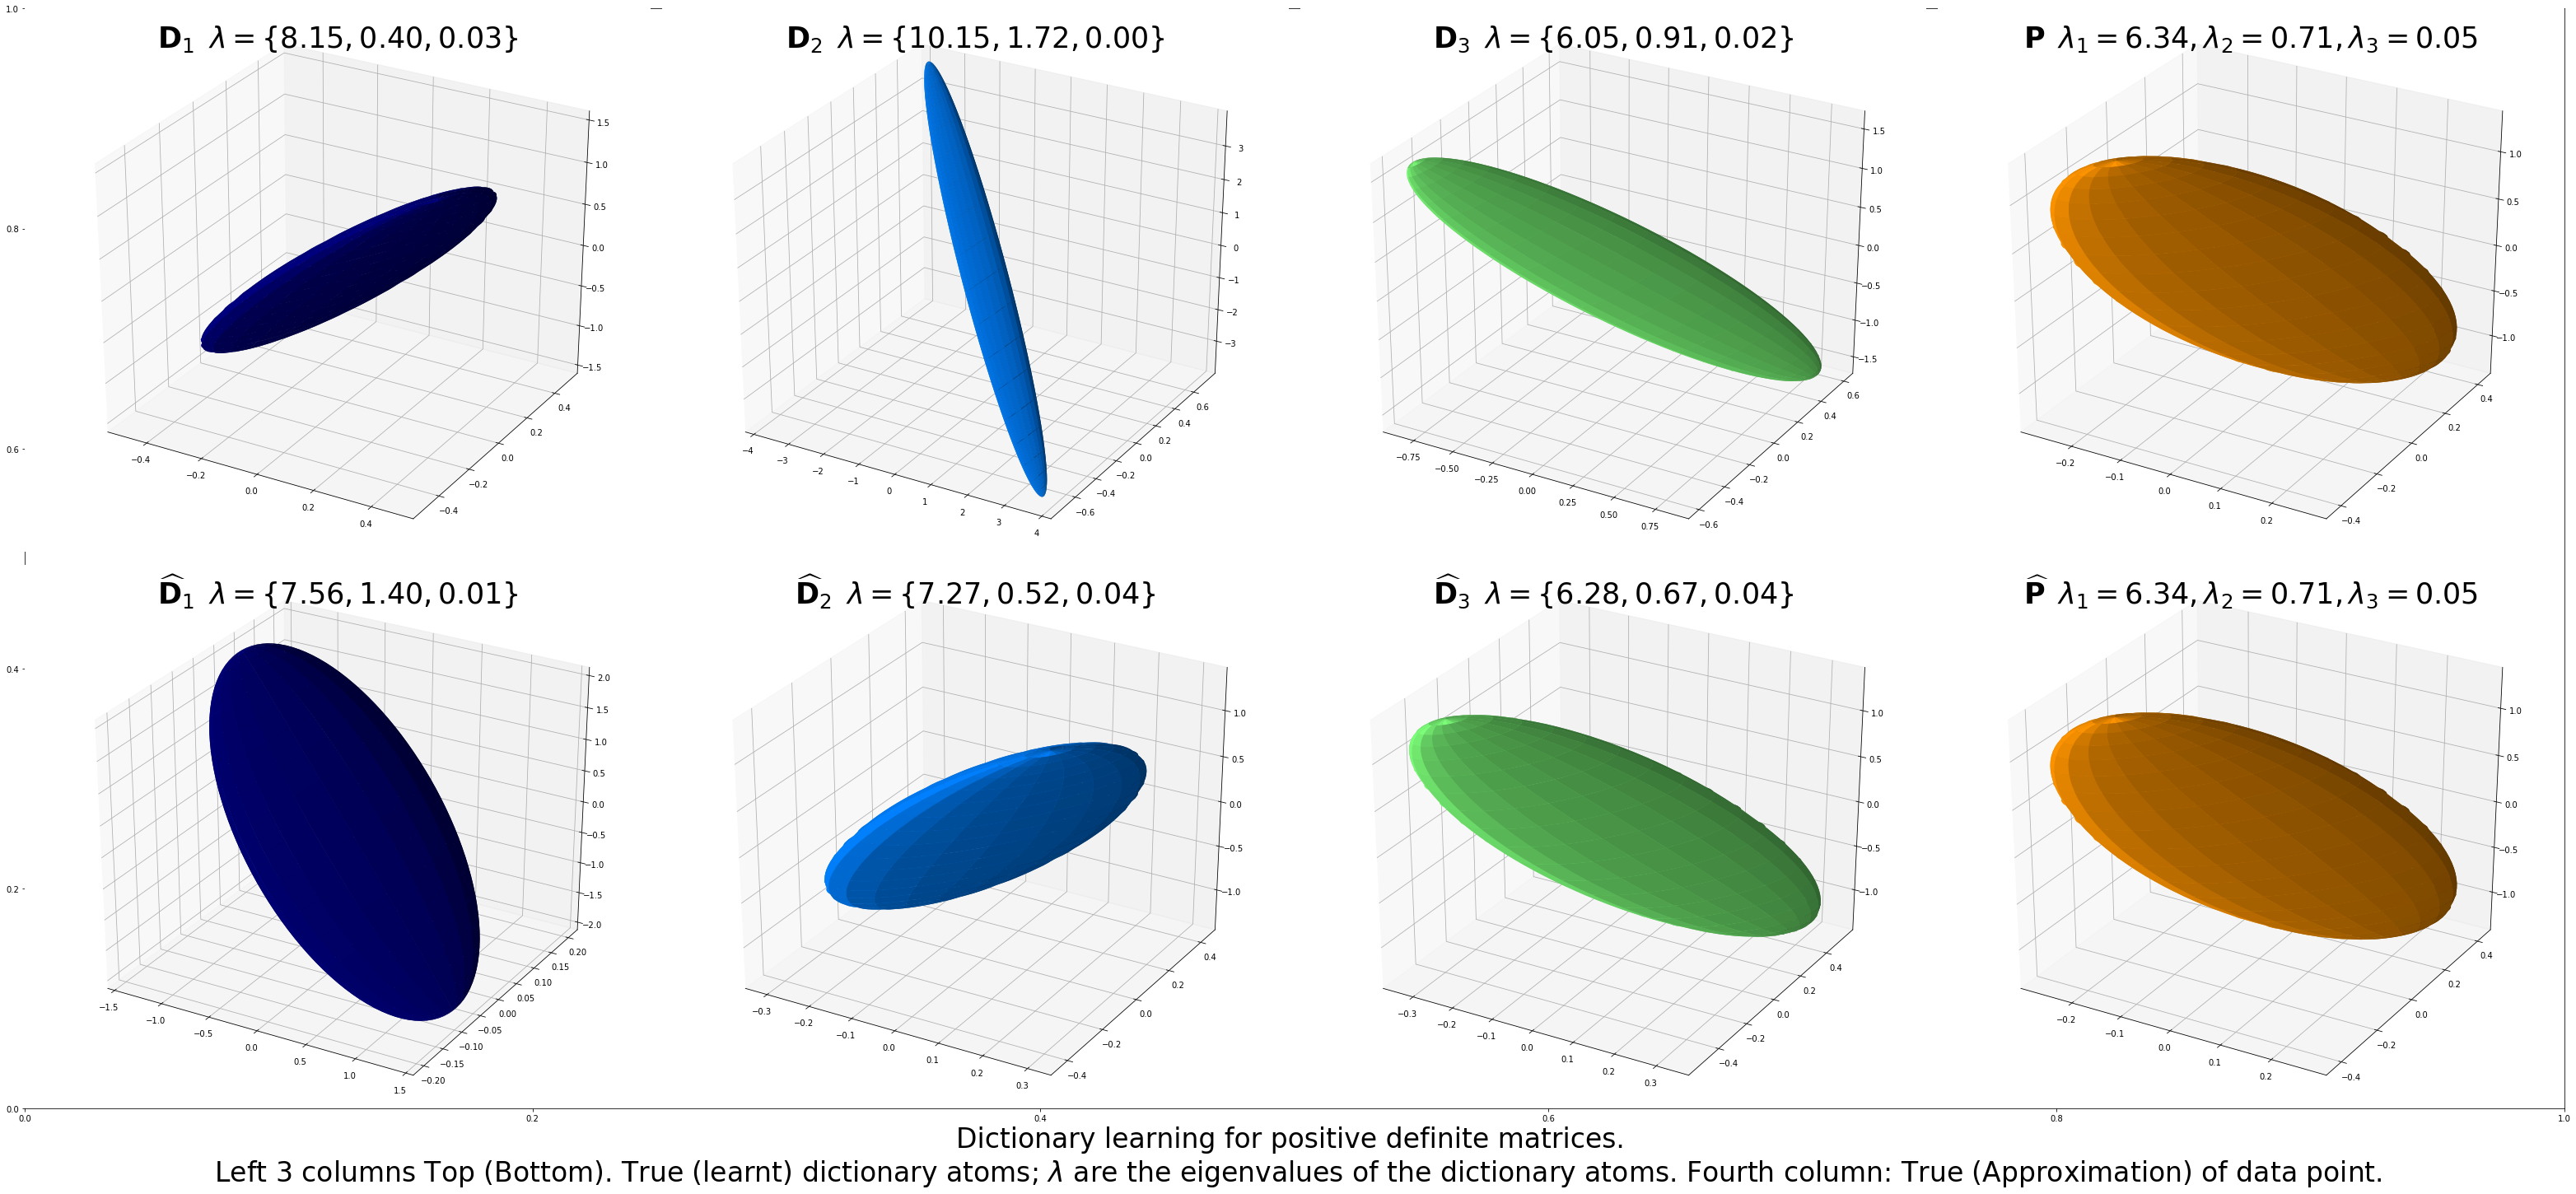

In [40]:
D_hat = torch.matmul(L, torch.transpose(L, 2, 1)) + e_I
D_hat = D_hat.detach()
alpha = alpha.detach()
pp   = PdfPages('wout_kds.pdf')
A    = torch.zeros((2*M+2,D,D))
A[0:M,:,:] = D_star
A[M+1:2*M+1,:,:] = D_hat
P          = barycenter_torch(D_star,alpha_star,sqrt_iter,fixed_iter,K,M,D)
for i in range(1):
        A[M,:,:]     = barycenter_torch(D_star,alpha_star[i,:].unsqueeze(0),sqrt_iter,fixed_iter,1,M,D) 
        A[2*M+1,:,:] = barycenter_torch(D_hat,alpha[i,:].unsqueeze(0),sqrt_iter,fixed_iter,1,M,D) 
        weights      = torch.cat((alpha_star[i,:],alpha[i,:]))
        plot_barycenter_example_3d(A,weights,pp,M)
pp.close()